In [1]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import harmonica as hm
from scipy import interpolate
import xarray as xr
import cmocean
from cmcrameri import cm
import geopandas as gpd
from skgstat import models
import gstatsim as gsm

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import animation

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time

import sys
sys.path.append('../../src')

import preprocessing
import block_update
import bouguer
import diagnostics
import rfgen
import utilities
import postprocessing
import gstatsim_custom

import importlib
importlib.reload(preprocessing)
importlib.reload(block_update)
importlib.reload(bouguer)
importlib.reload(diagnostics)
importlib.reload(rfgen)
importlib.reload(utilities)
importlib.reload(postprocessing)
importlib.reload(gstatsim_custom)

from preprocessing import *
from block_update import *
from bouguer import *
from diagnostics import *
from rfgen import *
from utilities import *
from postprocessing import *
from gstatsim_custom import *

In [2]:
bm_path = Path('G:/stochastic_bathymetry/raw_data/bedmachine/BedMachineAntarctica-v3.nc')
antgg_path = Path('D:/AntGG2021_allfiles/AntGG2021_Gravity_disturbance_at-surface.nc')

# MOA: https://nsidc.org/data/nsidc-0730/versions/1
moa_base = Path('G:/stochastic_bathymetry/raw_data/nsidc0730_MEASURES_MOA2014_v01')

# moa coast and grounding line
moa_coast = gpd.read_file(moa_base/'coastlines/moa2014_coastline_v01.shp')
moa_gl = gpd.read_file(moa_base/'coastlines/moa2014_grounding_line_v01.shp')
moa_island = gpd.read_file(moa_base/'coastlines/moa2014_islands_v01.shp')

glkm = moa_gl.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
coastkm = moa_coast.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
islandkm = moa_island.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')

In [3]:
ds = xr.load_dataset(Path('maudwest.nc'))
ds

<xarray.Dataset> Size: 2MB
Dimensions:       (y: 170, x: 140)
Coordinates:
  * x             (x) float64 1kB -7.975e+05 -7.925e+05 ... -1.025e+05
  * y             (y) float64 1kB 1.352e+06 1.358e+06 ... 2.192e+06 2.198e+06
Data variables:
    bed           (y, x) float32 95kB -464.7 -440.0 ... -2.543e+03 -2.481e+03
    surface       (y, x) float32 95kB -5.0 -5.0 -5.0 -5.0 ... 13.0 13.0 13.0
    thickness     (y, x) float32 95kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mask          (y, x) float64 190kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    geoid         (y, x) float64 190kB -5.0 -5.0 -5.0 -5.0 ... 13.0 13.0 13.0
    source        (y, x) float64 190kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    dataid        (y, x) float64 190kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    errbed        (y, x) float32 95kB 10.0 nan nan nan ... 10.0 10.0 10.0 10.0
    inv_msk       (y, x) bool 24kB False False False False ... False False False
    inv_pad       (y, x) bool 24kB False False False False ... False False False
    grav_surface  (y, x) float64 190kB -42.59 -40.43 -37.03 ... -33.95 -28.85
    grav_1500     (y, x) float64 190kB -40.34 -38.49 -35.56 ... -28.37 -23.9
Attributes:
    res:      5000

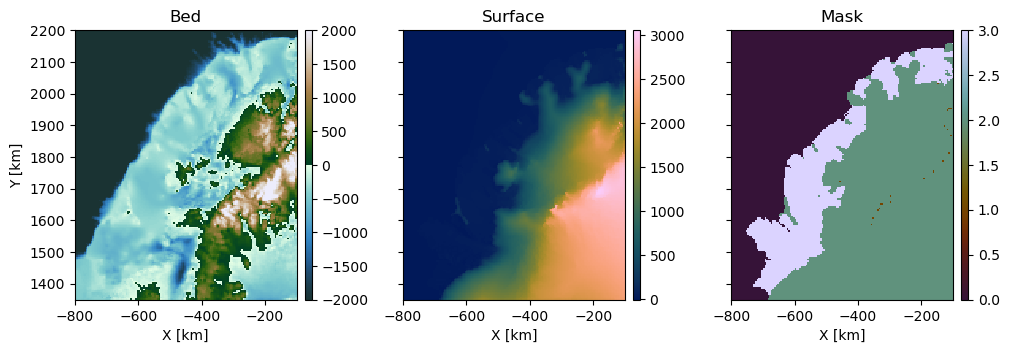

In [6]:
bedmachine_plots(ds, figsize=(12,3.5))

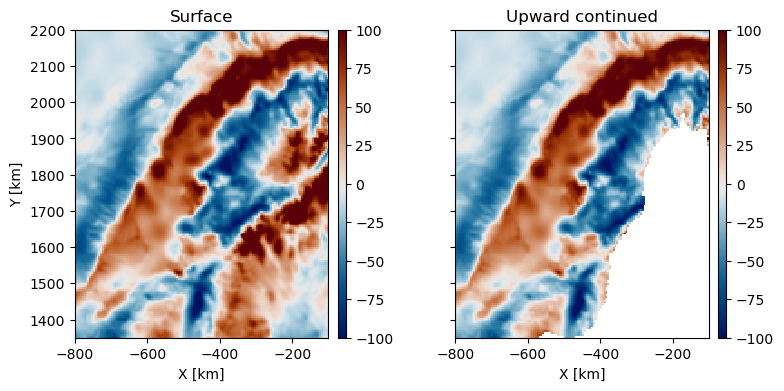

In [7]:
plot_gravity(ds, ds.grav_surface.values, ds.grav_1500.values, 1500, (9,4), 100)

In [8]:
grav = pd.read_csv('maudwest_grav.csv')

xx, yy = np.meshgrid(ds.x.values, ds.y.values)
grav_mask = ds.surface.values < 1500

print(f'{grav.shape[0]} points')
grav.head()

18466 points


,x,y,height,faa,inv_msk,inv_pad
0,-797500.0,1352500.0,1500,-40.338284,False,False
1,-792500.0,1352500.0,1500,-38.487764,False,False
2,-787500.0,1352500.0,1500,-35.561083,False,False
3,-782500.0,1352500.0,1500,-32.394329,False,False
4,-777500.0,1352500.0,1500,-30.324669,False,False


In [9]:
%%time

g_z = bm_terrain_effect(ds, grav)

CPU times: total: 6min 10s
Wall time: 25.5 s


In [10]:
g_z_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), g_z)
gdist_masked = np.where(grav_mask, ds.grav_1500.values, np.nan)
boug_grid = gdist_masked-g_z_grid

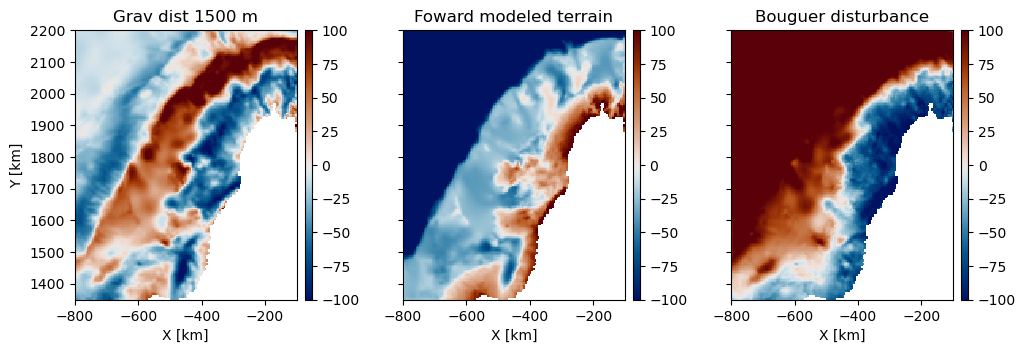

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12,3.5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, gdist_masked, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Grav dist 1500 m')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, g_z_grid, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Foward modeled terrain')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, boug_grid, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Bouguer disturbance')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

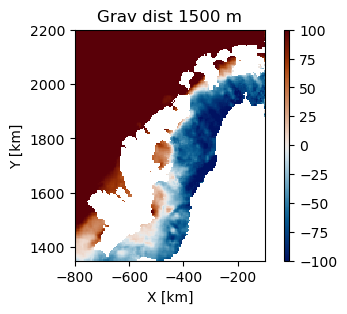

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,3), sharey=True)
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.where(ds.inv_msk, np.nan, boug_grid), cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Grav dist 1500 m')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [18]:
boug_dist = boug_grid[grav_mask]

trend = rbf_trend(ds, grav, boug_dist, smoothing=1e10, full_grid=True)
residual_grid = boug_grid-trend

trend.shape

(170, 140)

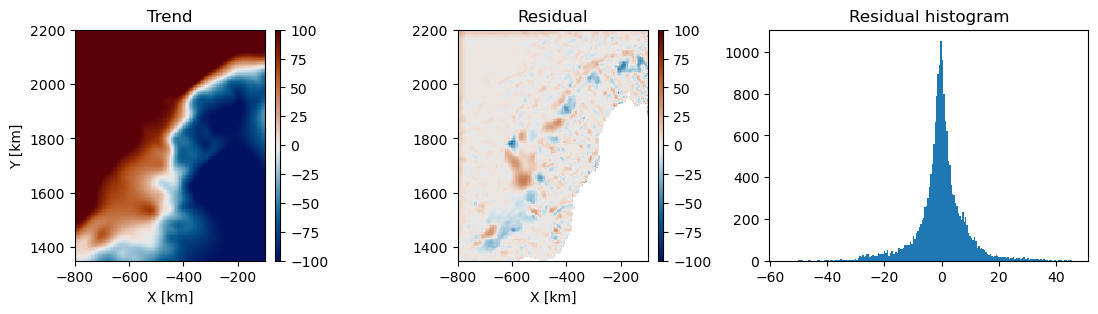

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14,3), sharey=False)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, trend, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Trend')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, residual_grid, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Residual')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
ax.hist(residual_grid.flatten(), bins=200)
ax.set_title('Residual histogram')

plt.show()

In [21]:
cond_msk = (np.abs(residual_grid)<25) & (ds.inv_msk==False)
res_grid_mod = np.where(cond_msk, residual_grid, np.nan)

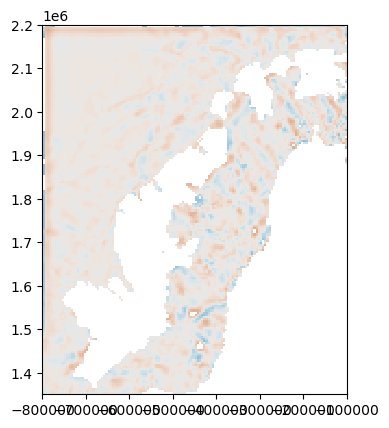

In [22]:
plt.pcolormesh(ds.x, ds.y, res_grid_mod, vmin=-100, vmax=100, cmap=cm.vik)
plt.axis('scaled')
plt.show()

In [23]:
vgrams, experimental, bins = do_variograms(xx, yy, res_grid_mod, maxlag=30e3, n_lags=20)

In [24]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

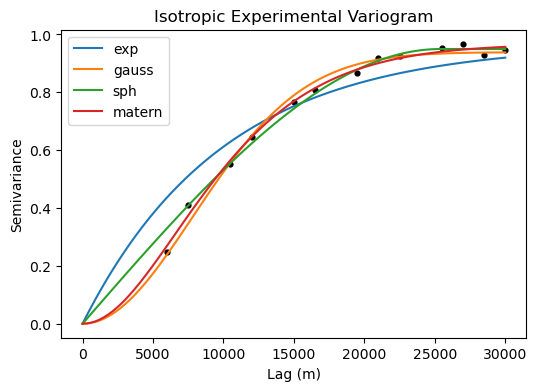

In [25]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [26]:
# random number generator
rng = np.random.default_rng(seed=0)

k = 50
rad = 500_000

parameters = vgrams['matern']

vario = {
    'azimuth' : 0,
    'nugget' : parameters[-1],
    'major_range' : parameters[0],
    'minor_range' : parameters[0],
    'sill' : parameters[1],
    'vtype' : 'matern',
    'smoothness' : parameters[2]
}

In [27]:
sim1 = sgs(xx, yy, res_grid_mod, vario, rad, k, sim_mask=ds.inv_msk.values, seed=rng)

  0%|          | 0/3995 [00:00<?, ?it/s]

In [28]:
sim2 = sgs(xx, yy, res_grid_mod, vario, rad, k, sim_mask=ds.inv_msk.values, seed=rng)

  0%|          | 0/3995 [00:00<?, ?it/s]

In [29]:
sim3 = sgs(xx, yy, res_grid_mod, vario, rad, k, sim_mask=ds.inv_msk.values, seed=rng)

  0%|          | 0/3995 [00:00<?, ?it/s]

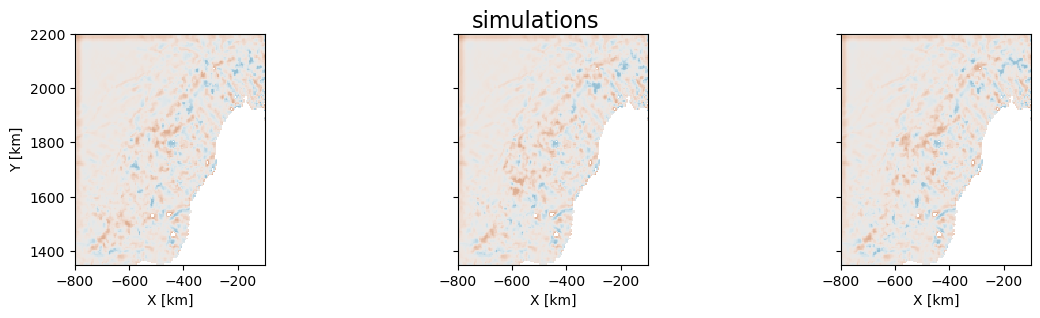

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(14,3), sharey=True)

sims = [sim1, sim2, sim3]
for sim, ax in zip(sims, axs):
    ax.pcolormesh(ds.x/1000, ds.y/1000, sim, cmap=cm.vik, vmin=-100, vmax=100)
    ax.axis('scaled')

axs[0].set_ylabel('Y [km]')
axs[0].set_xlabel('X [km]')
axs[1].set_xlabel('X [km]')
axs[2].set_xlabel('X [km]')

plt.suptitle('simulations', fontsize=16, y=0.96)

plt.show()

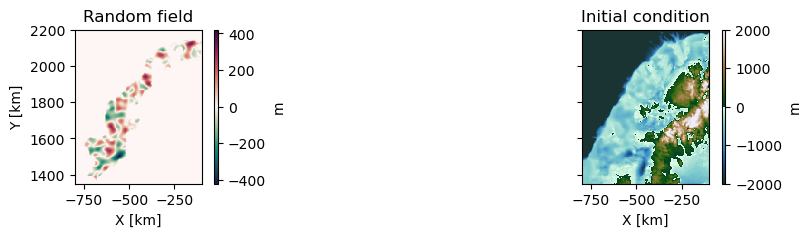

In [31]:
xkm = xx/1000
ykm = yy/1000

# make arrays for random field generation
range_max = [50e3, 50e3]
range_min = [30e3, 30e3]
high_step = 300
nug_max = 0.0
eps = 3e-4

rfgen = RFGen(ds, range_max, range_min, high_step, nug_max, eps, 'Gaussian', const_var=True, rng=rng)
field = rfgen.generate_field(condition=True)

x0 = ds.bed.values + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

vmax = np.max(np.abs(field))

fig, axs = plt.subplots(1, 2, figsize=(12,2), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, field, vmax=vmax, vmin=-vmax, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('Random field')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, label='m', pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, x0, vmax=2000, vmin=-2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_title('Initial condition')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, label='m', pad=0.03, aspect=40)

plt.show()

In [32]:
inv_pad = vd.distance_mask((xx[ds.inv_msk.values==True], yy[ds.inv_msk.values]), 20e3, (xx, yy))

density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}

grav_mskd = grav[grav.inv_pad==True]
pred_coords = (grav_mskd.x.values, grav_mskd.y.values, grav_mskd.height.values)

pred_coords[0].shape

(6384,)

In [33]:
vario

{'azimuth': 0,
 'nugget': 0,
 'major_range': np.float64(24419.290550961457),
 'minor_range': np.float64(24419.290550961457),
 'sill': np.float64(0.9678287748207592),
 'vtype': 'matern',
 'smoothness': np.float64(2.9207697900046825)}

# Resimulate parts of Bouguer

In [34]:
%%time

final_boug = boug_resample(ds, grav, sim, trend, cond_msk, k, vario, rad, rng, density_dict, max_iter_no_change=100, verbose=False)
final_boug = np.where(ds.inv_msk==False, residual_grid, final_boug)

CPU times: total: 8min 20s
Wall time: 54.3 s


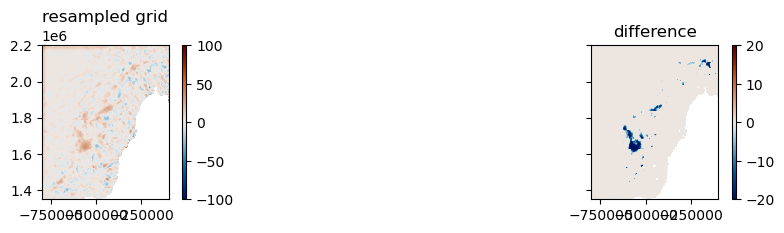

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(13,2), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xx, yy, final_boug, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('resampled grid')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(xx, yy, sim-final_boug, cmap=cm.vik, vmin=-20, vmax=20)
ax.axis('scaled')
ax.set_title('difference')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [36]:
target = grav.faa - (final_boug + trend)[grav_mask]

boug_filt = filter_boug(ds, grav, target, cutoff=20e3, pad=0)
target_filt = grav.faa.values - boug_filt
target_filt = target_filt[grav.inv_pad==True]
target_filt_grid = xy_into_grid(ds, (grav_mskd.x.values, grav_mskd.y.values), target_filt)

target = target[grav.inv_pad==True]
target_grid = xy_into_grid(ds, (grav_mskd.x.values, grav_mskd.y.values), target)

grav_mskd = grav[grav.inv_pad==True]

target.shape, grav_mskd.shape

((6384,), (6384, 6))

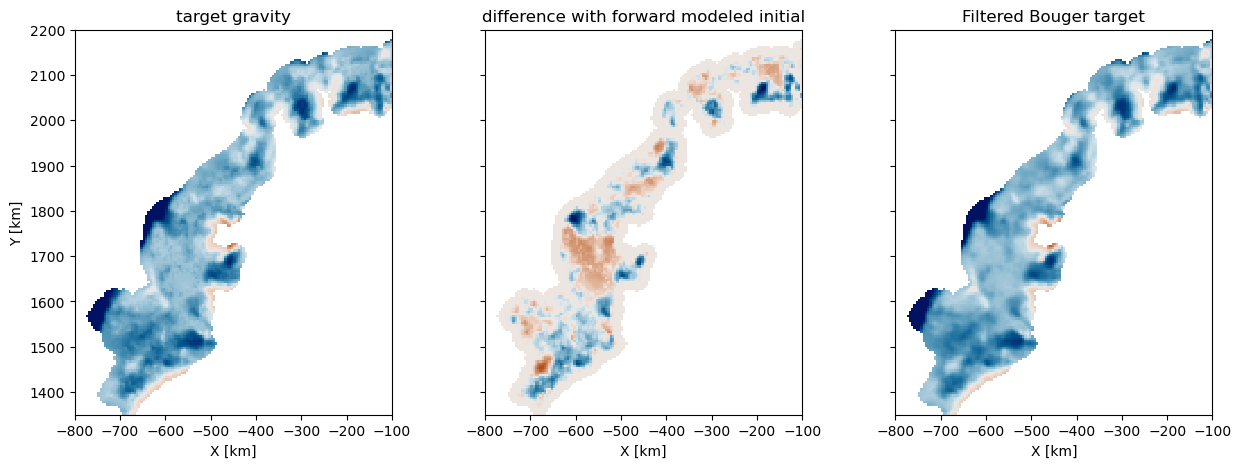

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax = axs[0]
ax.pcolormesh(xkm, ykm, target_grid, vmin=-100, vmax=100, cmap=cm.vik)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('target gravity')

ax = axs[1]
ax.pcolormesh(xkm, ykm, target_grid-g_z_grid, vmin=-50, vmax=50, cmap=cm.vik)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('difference with forward modeled initial')

ax = axs[2]
ax.pcolormesh(xkm, ykm, target_filt_grid, vmin=-100, vmax=100, cmap=cm.vik)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Filtered Bouger target')

plt.show()

In [38]:
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}

pred_coords = (grav_mskd.x.values, grav_mskd.y.values, grav_mskd.height.values)

pred_coords[0].shape, target.shape

((6384,), (6384,))

In [39]:
# block size, range, amplitude, iterations
sequence = [
    [21, 10, 60, 1000],
    [15, 8, 40, 1000],
    [9, 6, 40, 5000],
    [5, 5, 40, 10000]
]

# gravity uncertainty
sigma = 1.6

# RMSE stopping condition
stop = 2

# run chain sequence and time it
tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target_filt, sigma, density_dict, rng, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.167 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.062 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.034 RMSE/sec


  0%|          | 0/10000 [00:00<?, ?it/s]

chain 3 efficiency: -0.009 RMSE/sec
0 finished
total time: 133.4


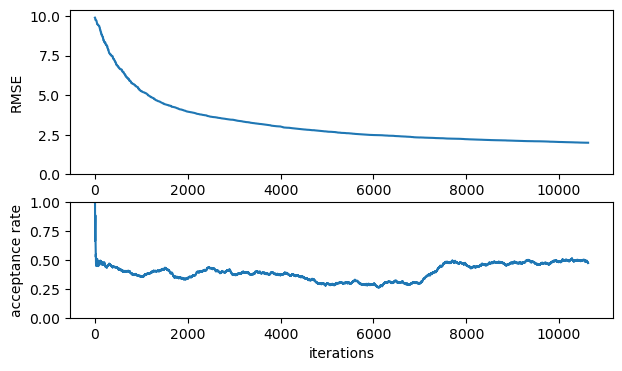

In [40]:
rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylim(0, np.max(rmse)+0.5)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

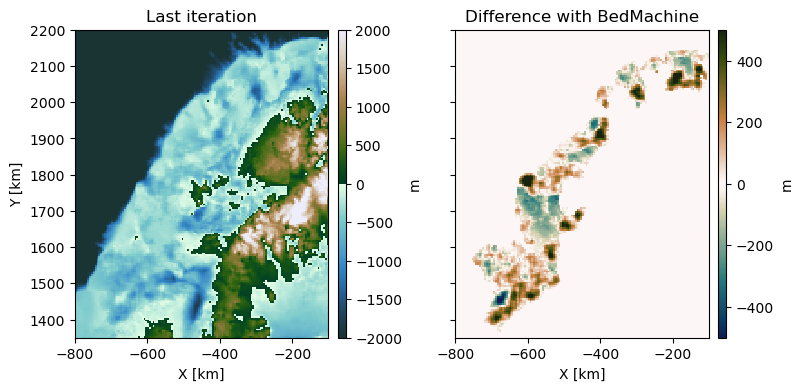

In [49]:
bed = result['bed_cache']

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(cm.bukavu, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

In [50]:
target_grid, grav_result_grid = xy_into_grid(ds, (pred_coords[0], pred_coords[1]), 
                                             (target_filt, result['grav_cache']))

grav_residual_grid = target_grid - grav_result_grid

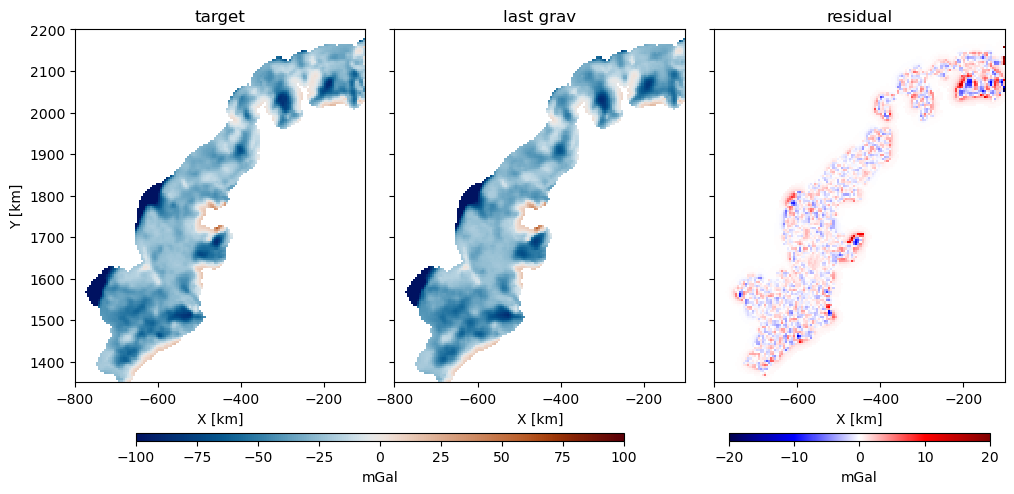

In [51]:
#fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

fig = plt.figure(figsize=(12,5.5))
gridspec = GridSpec(2, 3, height_ratios=[1, 0.02], wspace=0.1)

ax1 = fig.add_subplot(gridspec[0,0])
ax2 = fig.add_subplot(gridspec[0,1])
ax3 = fig.add_subplot(gridspec[0,2])

ax = ax1
im = ax.pcolormesh(xkm, ykm, target_grid, vmin=-100, vmax=100, cmap=cm.vik)
ax.axis('scaled')
ax.set_title('target')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = ax2
im = ax.pcolormesh(xkm, ykm, grav_result_grid, vmin=-100, vmax=100, cmap=cm.vik)
ax.axis('scaled')
ax.set_title('last grav')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:2])
cax = fig.add_subplot(gs2[10:90])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')

ax = ax3
im = ax.pcolormesh(xkm, ykm, grav_residual_grid, vmin=-20, vmax=20, cmap='seismic')
ax.axis('scaled')
ax.set_title('residual')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs3 = GridSpecFromSubplotSpec(1, 100, gridspec[1,2])
cax = fig.add_subplot(gs3[5:95])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

In [44]:
bed_filt = lowpass_filter_invpad(ds, bed, cutoff=20e3)
bed_filt = bed_filt.reshape(bed.shape)
bed_high = bed-bed_filt

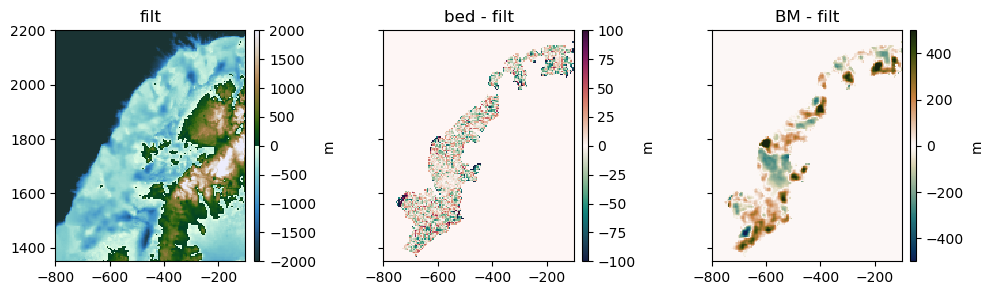

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(12,3), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_title('filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed-bed_filt, vmin=-100, vmax=100, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('bed - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('BM - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')
plt.show()

In [46]:
prisms, densities = make_prisms(ds, bed_filt, density_dict)
g_z = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

In [47]:
np.sqrt(np.mean(np.square(target-g_z)))

np.float64(2.5498955899202937)

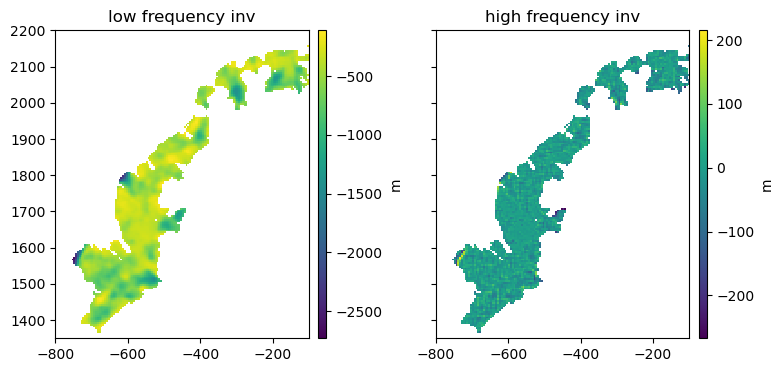

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)

ax = axs[0]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_filt, np.nan))
ax.axis('scaled')
ax.set_title('low frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_high, np.nan))
ax.axis('scaled')
ax.set_title('high frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()